In [1]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from LDMM import LDMNetSkorch, LDMNetDummy, LDMNetReg, plot_over_time
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import EarlyStopping, NaNStopping, MLP
from skorch.callbacks import LRScheduler

from sklearn.decomposition import PCA

random_state=0


### On the dummy model
- ksi = X is fixed all the time.
- L and W depend on ksi only, so they remain constant
- Z starts with 0
- Let M = c(L+ cW)^-1 W
- alpha_1 = M ksi
- Z_1 = alpha_1 - ksi
- alpha_2 = M (ksi - Z_1) = M (2*ksi - alpha_1)
- alpha_k+1 = M(2*ksi - alpha_k)
    - linear model x_k+1 = Ax_k + u_k, A = -M
    - eigen values of A all < 1 --> stable
    
### On the reg only model
- ksi starts with X, Z = 0 and alpha ?
- alpha_1 = Mk ksi_0
- ksi_1 = ksi_0 -lr * mu * (ksi_0 - Z_0 + alpha_1)
- Z_1 = Z_0 + alpha_1 - ksi_1
- alpha_1 = Mk ksi_1 - Mk Z_1
- M changes every k because it depends on ksi. If lr is low, ksi and M should not change too much.

## Line randomly projected to higher D

In [2]:
m = 100
x1 = np.linspace(-1.0, 1.0, m)
x2 = 1*x1
x = np.stack([x1,x2], axis=-1)
np.random.seed(random_state)
d = 10
P = np.random.rand(x.shape[1], d)
X = np.matmul(x,P)
# s=0.5*d
# noise = s*np.random.rand(*X.shape)
# X += noise
y = np.zeros(m)
y[m//2:] +=1

(-4.323452258577454,
 4.323452258577456,
 7.963223934898786e-17,
 8.64690451715491)

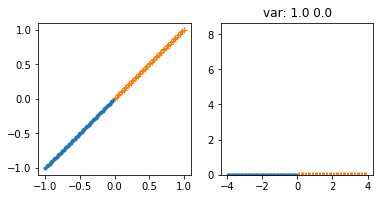

In [3]:
plt.figure()
plt.subplot(1,2, 1)
plt.plot(*x[y==0,0:2].T, '.')
plt.plot(*x[y==1,0:2].T, '+')
plt.axis('square')
proj = PCA(n_components=2, random_state=random_state)
X2d = proj.fit_transform(X)
plt.subplot(1,2, 2)
plt.plot(*X2d[y==0].T, '.')
plt.plot(*X2d[y==1].T, '+')
plt.title("var: %0.1f %0.1f" % tuple(proj.explained_variance_ratio_[0:2]))
plt.axis('square')

### Dummy model

In [4]:
dummy_model = LDMNetDummy(mu=1e-1, lambda_bar=1, max_epochs=500, concatenate_input=False)

In [5]:
W = dummy_model._compute_W(X)
L = dummy_model._compute_L(W)
c = dummy_model.mu/dummy_model.lambda_bar
# Solve Ax = b
A = (L + c*W).tocsc()
invA = sparse.linalg.spilu(A, drop_tol=1e-5, fill_factor=50)
M = c * invA.solve(W.todense())
np.abs(np.linalg.eigvals(-M))[:10], np.all(np.abs(np.linalg.eigvals(-M)) < 1.0)

(array([1.        , 0.88394669, 0.65072267, 0.44380752, 0.29853288,
        0.20235729, 0.13851326, 0.09520376, 0.06508945, 0.04369842]), False)

In [6]:
dummy_model.fit(X,y)

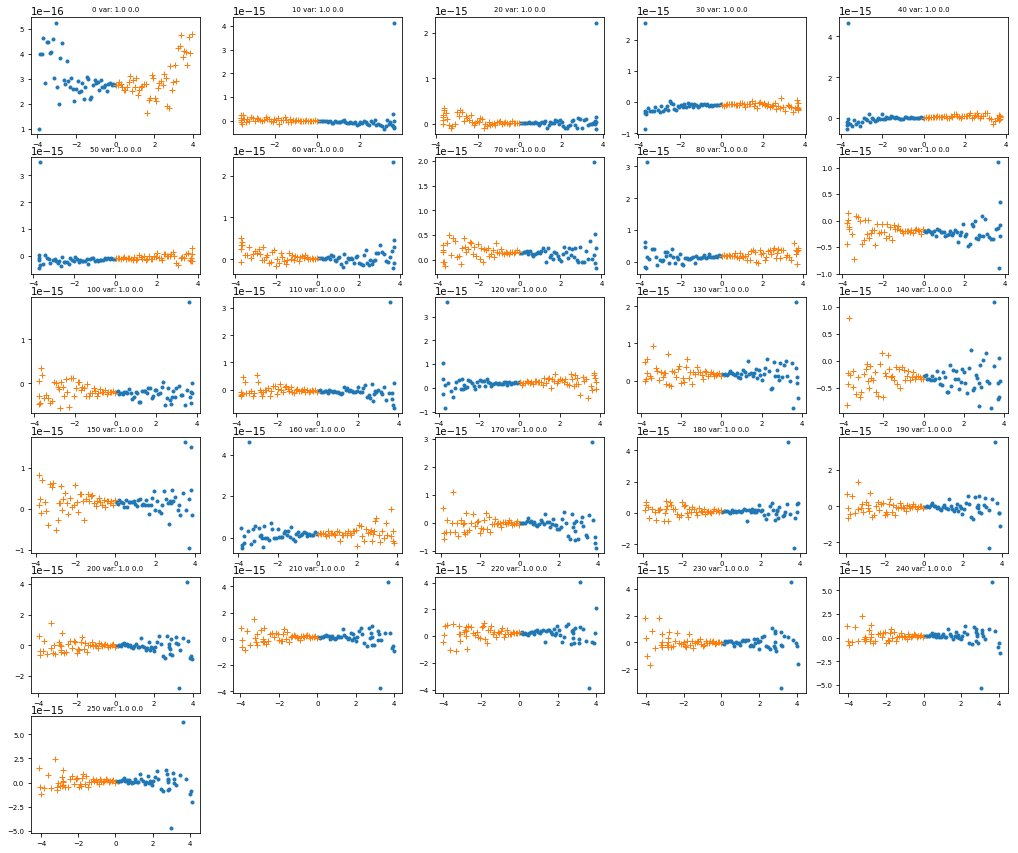

In [7]:
plot_over_time(dummy_model, 'alpha', every_n=10, y=y)

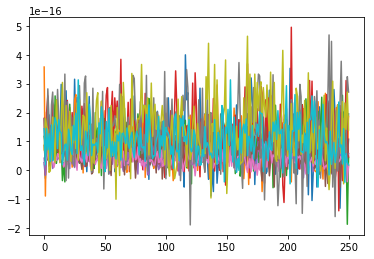

In [8]:
alpha = np.stack(dummy_model.alpha, axis=-1)
alpha = alpha.transpose([1,0,2])
plt.figure()
for feature in alpha:
    plt.plot(feature.mean(axis=0))

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/pca.py:445: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


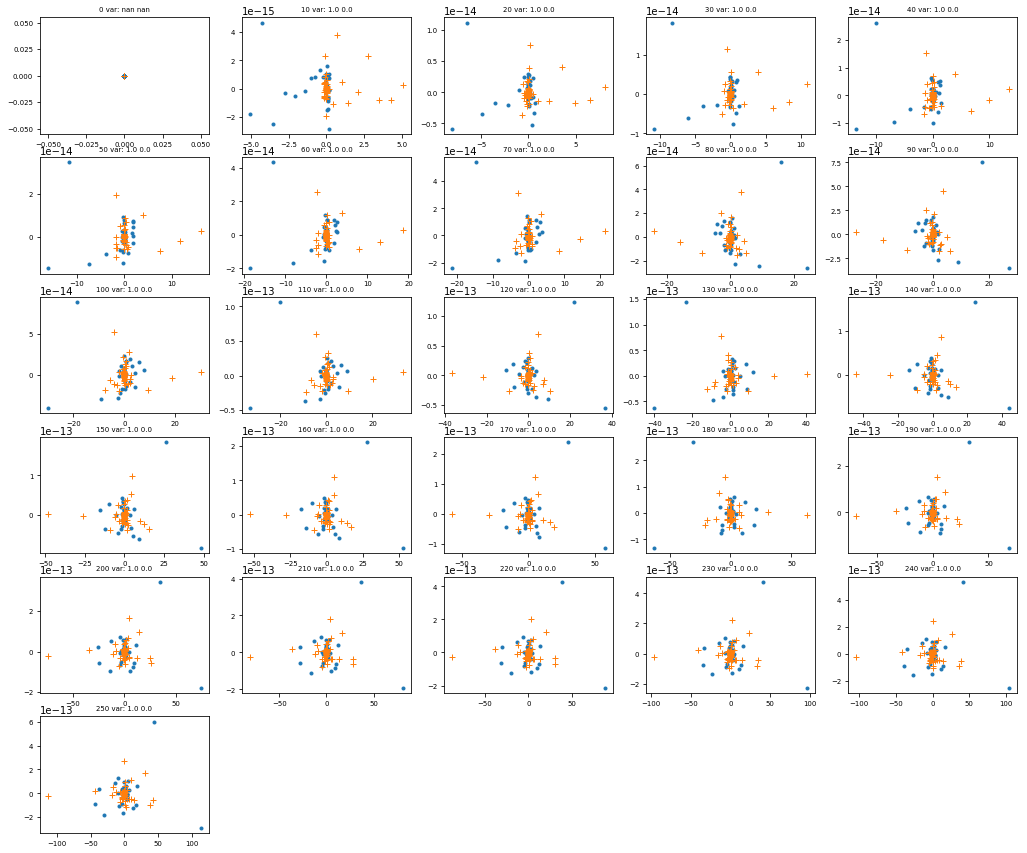

In [9]:
plot_over_time(dummy_model, 'Z', every_n=10, y=y)

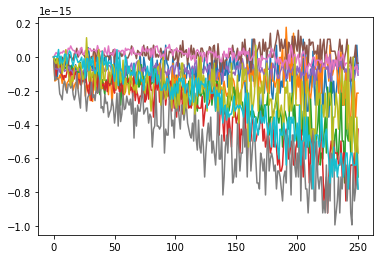

In [10]:
Z = np.stack(dummy_model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))

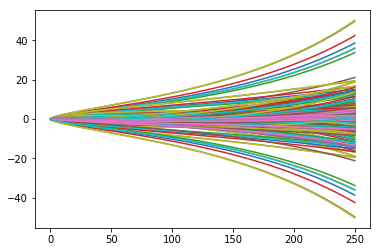

In [11]:
Z = np.stack(dummy_model.Z, axis=-1)
plt.figure()
for sample in Z:
    for feature in sample:
        plt.plot(feature)

### Only reg loss model

In [12]:
reg_model = LDMNetReg(mu=1e-3, lambda_bar=1e-2, lr=1)
ksi = reg_model.fit_transform(X,y)

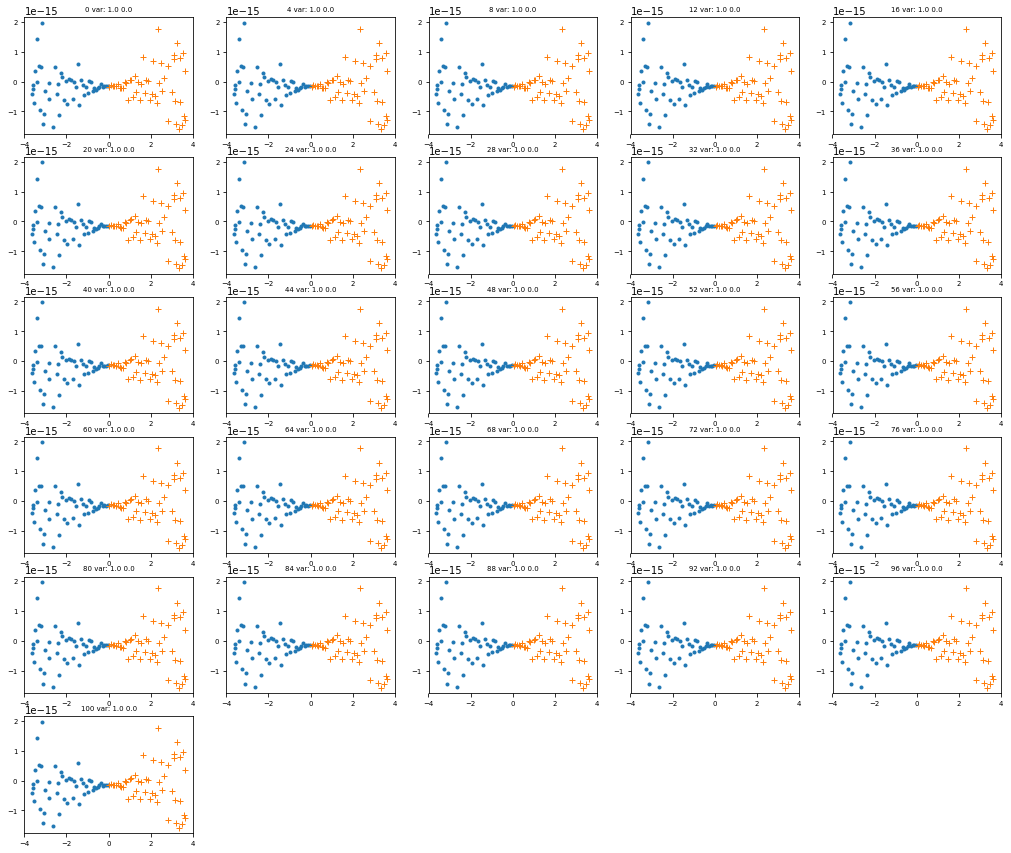

In [14]:
plot_over_time(reg_model, 'ksi', every_n=4, y=y)

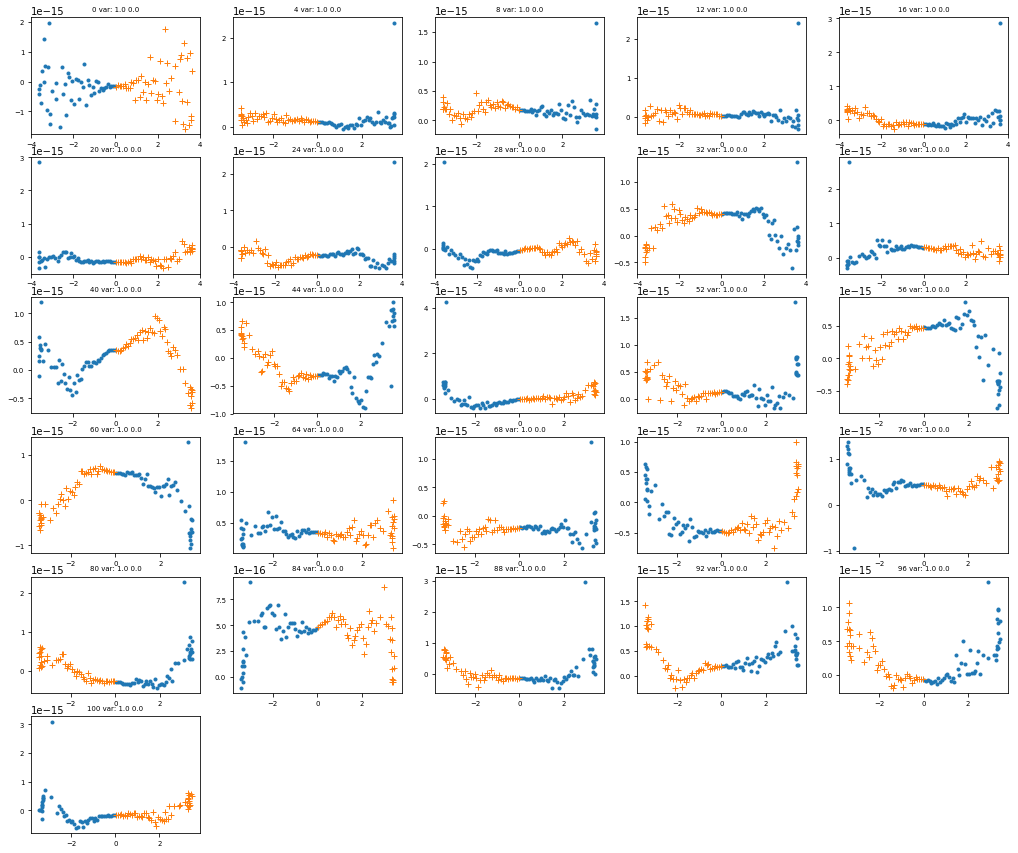

In [15]:
plot_over_time(reg_model, 'alpha', every_n=4, y=y)

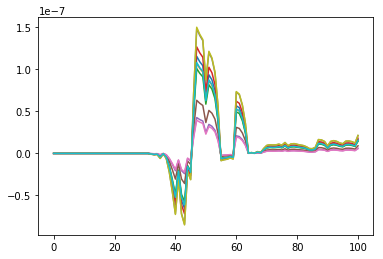

In [16]:
Z = np.stack(reg_model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))

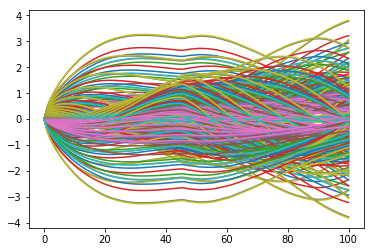

In [17]:
Z = np.stack(reg_model.Z, axis=-1)
plt.figure()
for sample in Z:
    for feature in sample:
        plt.plot(feature)